In [ ]:
!python -m pip install -U langchain-google-genai

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm.invoke("hello").content

'Hello! How can I help you today?'

Load data

In [2]:
import pandas as pd  
  
def xlsx_to_string(file_path):  
    try:  
        df = pd.read_csv(file_path)  
        content = df.to_csv(index=False)  
        return content  
    except Exception as e:  
        print("Error: ", str(e))  
  
# Usage example  
file_path = r"C:\Users\Acer\Downloads\16_Clariant\sample-data.csv"
content_string = xlsx_to_string(file_path)  
print(content_string)  

Year,Month,Revenue,Manpower Cost,Non-Manpower Cost,Total Cost,Profit,Contribution Margin (%)
2020,1,154676,39721,17582,57303,97373,62.95
2020,2,164365,61057,26411,87468,76897,46.78
2020,3,132052,43382,21930,65312,66740,50.54
2020,4,165124,20234,39344,59578,105546,63.92
2020,5,104947,26641,22843,49484,55463,52.85
2020,6,181897,37485,10027,47512,134385,73.88
2020,7,147839,23570,17982,41552,106287,71.89
2020,8,113569,38550,33589,72139,41430,36.48
2020,9,89551,42996,39201,82197,7354,8.21
2020,10,167898,49868,32513,82381,85517,50.93
2020,11,165184,27059,11489,38548,126636,76.66
2020,12,76217,57088,22519,79607,-3390,-4.45
2021,1,58243,39043,35763,74806,-16563,-28.44
2021,2,199287,34254,23773,58027,141260,70.88
2021,3,138678,20040,11554,31594,107084,77.22
2021,4,64844,30692,33766,64458,386,0.6
2021,5,79712,29907,45565,75472,4240,5.32
2021,6,197350,35838,32720,68558,128792,65.26
2021,7,73012,60455,21656,82111,-9099,-12.46
2021,8,148743,31861,17442,49303,99440,66.85
2021,9,137461,51745,45653,97

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

query=f"""You are a financial expert with years of experience, deeply analyze the given data. Which contains valuable financial information about a company's performance, and then provide with comprehensive answers to user questions based on your thorough analysis.

Rules 1. Please avoid creating charts or graphs, as well as writing any code. Provide a simple and direct response using natural language without mentioning any limitations or rules.
{content_string}
"""
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            query,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
print(prompt_template)

input_variables=['messages'] input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.Funct

In [4]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage
# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = llm.invoke(prompt)
    return {"messages": response}

# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "abc123"}}

In [5]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
def execute_matplotlib_code(MATPLOTLIB_CODE):
    python_repl = PythonREPL()
    return python_repl.run(MATPLOTLIB_CODE)
    

In [6]:
import re
def llm_call_for_matplotlib(user_query, response):
    matplotlib_query = f"User query: {user_query}"
    matplotlib_query += f"\nAnswer: {response}"
    
    matplotlib_query += f"\n\nProvided an answer to a user query, write a matplotlib code for either a bar chart, scatter chart, a histogram, or line chart based on the given information. If it is not possible to create a graph, no code will be generated. Please make sure to write a Matplotlib code using only the information given in the user query or answer. Do not make any assumptions on your own. Strictly your output should consist of only Python code, without any additional text. The graph should be only generated from the user query and answer. If no graph can be genrated leave it blank. "
    print(matplotlib_query)
    
    result = llm.invoke(matplotlib_query).content
    result = re.sub(r"python|```", "", result)
    return result

# user_query = "In Which year was my sales maximum."
# response = """ 
# To determine the year with the maximum sales (revenue), we need to sum the revenue for each year and compare the totals.
# Here are the total revenues for each year:
# - 2020: 1,748,215
# - 2021: 1,548,561
# - 2022: 1,678,708
# - 2023: 1,451,712 (up to December)
# - 2024: 1,548,140 (up to December)
# - 2025: 1,548,158 (up to December)
# From the data provided, the year 2020 had the maximum sales with a total revenue of 1,748,215.
# """
# result = llm_call_for_matplotlib(user_query, response)
# execute_matplotlib_code(result)


================================== Ai Message ==================================
Here's a comparison of the overall Total Costs for the years 2020, 2021, 2024, and 2025:

*   **2020 Total Cost:** $708,733
*   **2021 Total Cost:** $831,828
*   **2024 Total Cost:** $799,440
*   **2025 Total Cost:** $804,560

**Comparison:**

*   2024's total cost is higher than 2020's by $90,707.
*   2024's total cost is lower than 2021's by $32,388.
*   2024's total cost is lower than 2025's by $5,120.
================================== Matplotlib ==================================
User query: My overall cosy in year 2024 compared to year 2025, 2021, 2020
Answer: Here's a comparison of the overall Total Costs for the years 2020, 2021, 2024, and 2025:

*   **2020 Total Cost:** $708,733
*   **2021 Total Cost:** $831,828
*   **2024 Total Cost:** $799,440
*   **2025 Total Cost:** $804,560

**Comparison:**

*   2024's total cost is higher than 2020's by $90,707.
*   2024's total cost is lower than 2021's by 

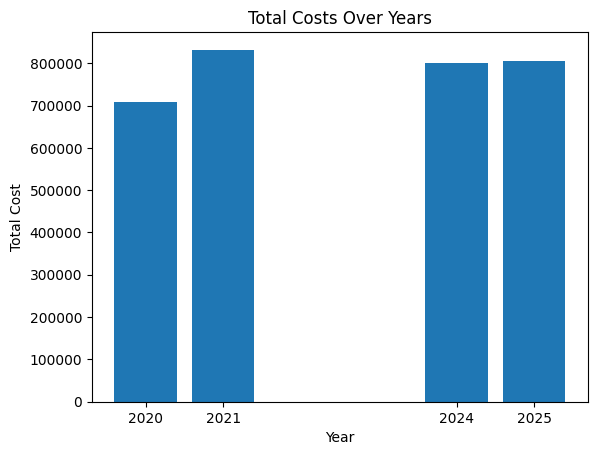

''

In [17]:
### saves history and runs great
user_query = "My overall cosy in year 2024 compared to year 2025, 2021, 2020"
input_messages = [HumanMessage(user_query)]
output = app.invoke({"messages": input_messages}, config)
print("================================== Ai Message ==================================")
response = output["messages"][-1].content
print(response)
print("================================== Matplotlib ==================================")
result = llm_call_for_matplotlib(user_query, response)
execute_matplotlib_code(result)

================================== Ai Message ==================================
The year with the maximum sales (Revenue) was 2025, with a total revenue of $1,541,173.

Here's a detailed breakdown of why 2025 had the highest sales:

*   **Consistent Performance:** While some months in 2025 experienced losses, the majority of the months showed strong revenue generation. There were several months with revenue exceeding $150,000.
*   **Strong Contribution Margins:** The contribution margins in 2025 were generally healthy, with many months exceeding 50%. This indicates efficient cost management relative to revenue.
*   **High Revenue Months:** Months like May, June, July, September, October and November had very high revenue figures, significantly contributing to the overall annual revenue. September had the highest contribution margin of 73.75%
*   **Recovery from Losses:** Even though the year started with a significant loss in January, the subsequent months demonstrated a strong recove

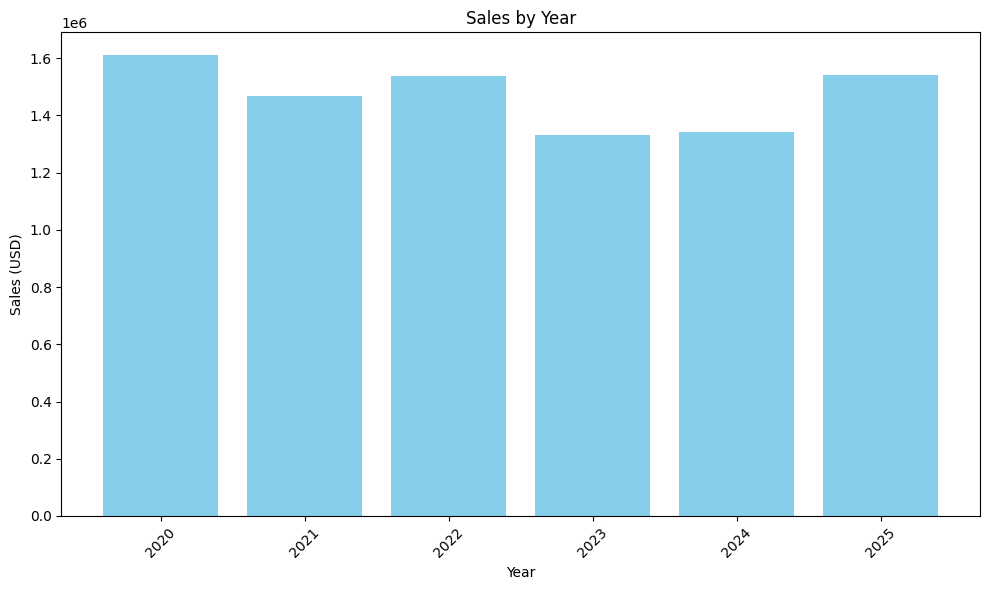

''

In [18]:
### saves history and runs great
user_query = "Which year i had maximum sales and why give me a detailed response.? Also show me sales for other years"
input_messages = [HumanMessage(user_query)]
output = app.invoke({"messages": input_messages}, config)
print("================================== Ai Message ==================================")
response = output["messages"][-1].content
print(response)
print("================================== Matplotlib ==================================")
result = llm_call_for_matplotlib(user_query, response)
execute_matplotlib_code(result)

================================== Ai Message ==================================
Here's a breakdown of sales (Revenue) for each month from 2020 to 2025:

**2020:**

*   January: $154,676
*   February: $164,365
*   March: $132,052
*   April: $165,124
*   May: $104,947
*   June: $181,897
*   July: $147,839
*   August: $113,569
*   September: $89,551
*   October: $167,898
*   November: $165,184
*   December: $76,217

**2021:**

*   January: $58,243
*   February: $199,287
*   March: $138,678
*   April: $64,844
*   May: $79,712
*   June: $197,350
*   July: $73,012
*   August: $148,743
*   September: $137,461
*   October: $143,006
*   November: $57,863
*   December: $129,542

**2022:**

*   January: $161,846
*   February: $80,598
*   March: $88,066
*   April: $67,824
*   May: $87,168
*   June: $134,461
*   July: $149,882
*   August: $129,669
*   September: $176,616
*   October: $194,980
*   November: $129,698
*   December: $148,412

**2023:**

*   January: $75,498
*   February: $77,142
*   M

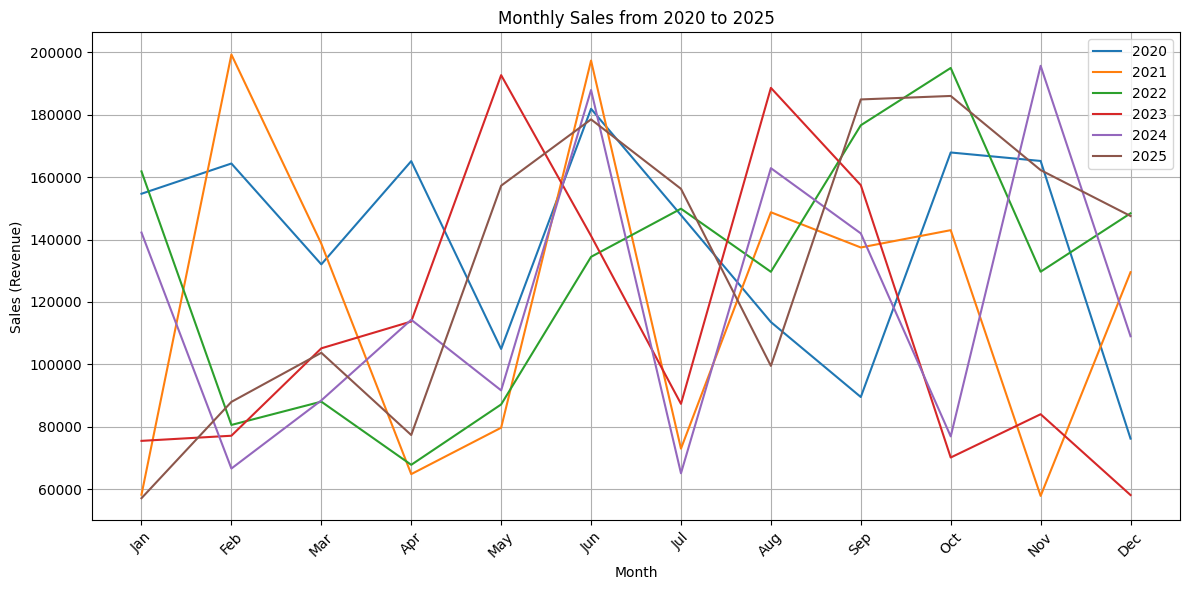

''

In [11]:
### saves history and runs great
user_query = "I want sales from year 2020 to 2025 with respect to every month in those years?"
input_messages = [HumanMessage(user_query)]
output = app.invoke({"messages": input_messages}, config)
print("================================== Ai Message ==================================")
response = output["messages"][-1].content
print(response)
print("================================== Matplotlib ==================================")
result = llm_call_for_matplotlib(user_query, response)
execute_matplotlib_code(result)